# Option-Implied Probability  
This script is inspired by https://reasonabledeviations.com/2020/10/01/option-implied-pdfs/

In [2]:
#import nasdaqdatalink
#raw_sb = nasdaqdatalink.get("CHRIS/CME_BO1")

# Downloaded from: https://www.barchart.com/futures/quotes/ZL*0/options?moneyness=20
import pandas as pd
raw_sbo = pd.read_csv('zlf23-options-american-options-exp-12_23_22-20-strikes-intraday-11-25-2022.csv')
raw_sbo.head(10)

,Strike,High,Low,Last,Change,Bid,Ask,Volume,Open Int,Premium,Last Trade
0,67.500C,5.545,5.545,5.545,0.570,5.380,5.500,NaN,74.0,3327,11/23/22
1,67.500P,0.980,0.860,0.860,-0.185,0.775,0.795,24.0,124.0,516,11/23/22
2,68.000C,5.170,5.170,5.170,0.555,4.990,5.115,NaN,84.0,3102,11/23/22
3,68.000P,1.300,0.980,0.980,-0.205,0.890,0.910,832.0,1938.0,588,11/23/22
4,68.500C,4.805,4.805,4.805,0.530,4.630,4.740,NaN,33.0,2883,11/23/22
5,68.500P,1.260,1.115,1.115,-0.225,1.020,1.040,41.0,157.0,669,11/23/22
6,69.000C,4.450,3.695,4.450,0.505,4.280,4.375,1.0,211.0,2670,11/23/22
7,69.000P,1.105,1.105,1.105,-0.155,1.160,1.185,194.0,1063.0,663,08:51 CT
8,69.500C,4.275,4.275,4.275,0.160,3.965,4.015,10.0,112.0,2565,08:52 CT
9,69.500P,1.385,1.265,1.265,-0.155,1.320,1.345,25.0,475.0,759,08:52 CT


In [3]:
def clean_options(df):
    # Fix Types
    import numpy as np
    df = df.replace(np.nan,0)
    df.Volume = df.Volume.astype(int)
    df['Open Int'] = df['Open Int'].astype(int)

    # Separate Columns
    df['Strike Price'] = df.Strike.str.extract('(\d+\.\d+)').astype(float)
    df['Type'] = df.Strike.str[-1]
    df.Type = df.Type.replace({'C': 'Call', 'P': 'Put'})
    df = df.drop(['Strike'], axis=1)

    # Fix Date
    #df['Last Trade'] = pd.to_datetime(df['Last Trade'], utc=True).map(lambda x: x.tz_convert('America/Chicago'))
    df['Last Trade'] = df['Last Trade'].str.replace('CT', '', regex=True)
    df['Last Trade'] = pd.to_datetime(df['Last Trade']).dt.tz_localize('America/Chicago')
    return df

sbo = clean_options(raw_sbo)

sbo=sbo[['Last Trade','Strike Price','Type','Last','Volume','Open Int','Premium']]
sbo.head(10)

,Last Trade,Strike Price,Type,Last,Volume,Open Int,Premium
0,2022-11-23 00:00:00-06:00,67.5,Call,5.545,0,74,3327
1,2022-11-23 00:00:00-06:00,67.5,Put,0.860,24,124,516
2,2022-11-23 00:00:00-06:00,68.0,Call,5.170,0,84,3102
3,2022-11-23 00:00:00-06:00,68.0,Put,0.980,832,1938,588
4,2022-11-23 00:00:00-06:00,68.5,Call,4.805,0,33,2883
5,2022-11-23 00:00:00-06:00,68.5,Put,1.115,41,157,669
6,2022-11-23 00:00:00-06:00,69.0,Call,4.450,1,211,2670
7,2022-11-26 08:51:00-06:00,69.0,Put,1.105,194,1063,663
8,2022-11-26 08:52:00-06:00,69.5,Call,4.275,10,112,2565
9,2022-11-26 08:52:00-06:00,69.5,Put,1.265,25,475,759


In [33]:
def get_probs(strikes, prices):
    import numpy as np
    l_strike, m_strike, u_strike = [], [], []
    l_price, m_price, u_price = [], [], []

    for i in np.arange(0,len(strikes)):
        if (i>0) & (i<len(strikes)-1):
            l_strike.append(strikes.iloc[i-1])
            l_price.append(prices.iloc[i-1])
            m_strike.append(strikes.iloc[i])
            m_price.append(prices.iloc[i])
            u_strike.append(strikes.iloc[i+1])
            u_price.append(prices.iloc[i+1])
    
    # For each strike price, calculate the probability, p
    p=[]
    s=[]
    for i in np.arange(0,len(m_strike)):
        ms = m_strike[i]
        lp = l_price[i]
        mp = m_price[i]
        up = u_price[i]

        # Calculate the probability a future expires at the target price
        prob = lp - (2 * mp) + up
        s.append(ms)
        p.append(prob)
    
    return(pd.DataFrame({'Strike Price': s,'Probability':p}))

# Filter Call Strikes and Prices
c_sbo = sbo[sbo.Type == 'Call']

p = get_probs(c_sbo['Strike Price'], c_sbo['Last'])
c_sbo = c_sbo.merge(p, how='left')
c_sbo

,Last Trade,Strike Price,Type,Last,Volume,Open Int,Premium,Probability
0,2022-11-23 00:00:00-06:00,67.5,Call,5.545,0,74,3327,NaN
1,2022-11-23 00:00:00-06:00,68.0,Call,5.170,0,84,3102,0.010
2,2022-11-23 00:00:00-06:00,68.5,Call,4.805,0,33,2883,0.010
3,2022-11-23 00:00:00-06:00,69.0,Call,4.450,1,211,2670,0.180
4,2022-11-26 08:52:00-06:00,69.5,Call,4.275,10,112,2565,-0.305
5,2022-11-23 00:00:00-06:00,70.0,Call,3.795,5,539,2277,0.170
6,2022-11-23 00:00:00-06:00,70.5,Call,3.485,1,449,2091,0.020
7,2022-11-23 00:00:00-06:00,71.0,Call,3.195,371,633,1917,0.015
8,2022-11-23 00:00:00-06:00,71.5,Call,2.920,25,252,1752,0.020
9,2022-11-23 00:00:00-06:00,72.0,Call,2.665,329,1406,1599,0.015


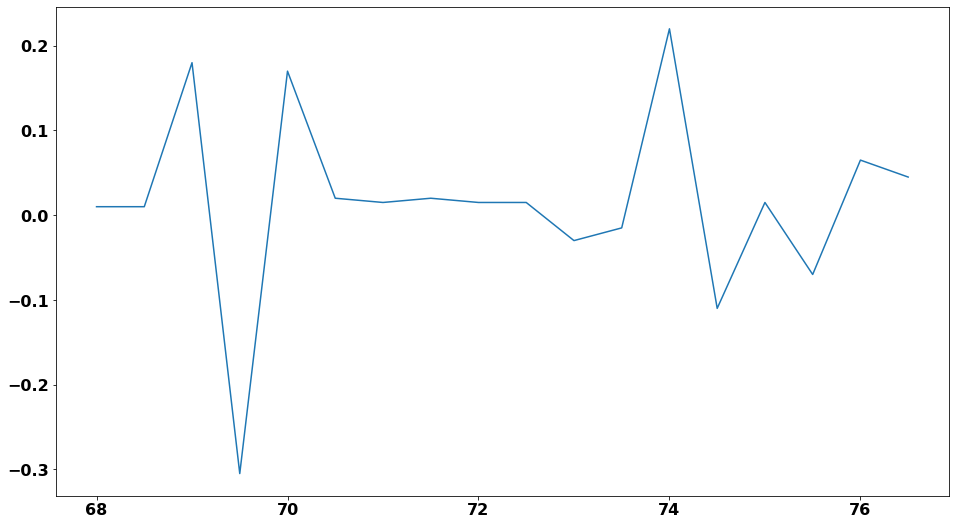

In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.weight': 'bold', 'figure.figsize': (16,9)})

df=c_sbo.dropna(axis=0)
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(df['Strike Price'],df['Probability'])

In [ ]:
# Fit cubic spline, a gaussian distribution fit on the probabilities of each target strike price
